/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/354732240.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').sum()
/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/354732240.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq('M', fill_value=0)


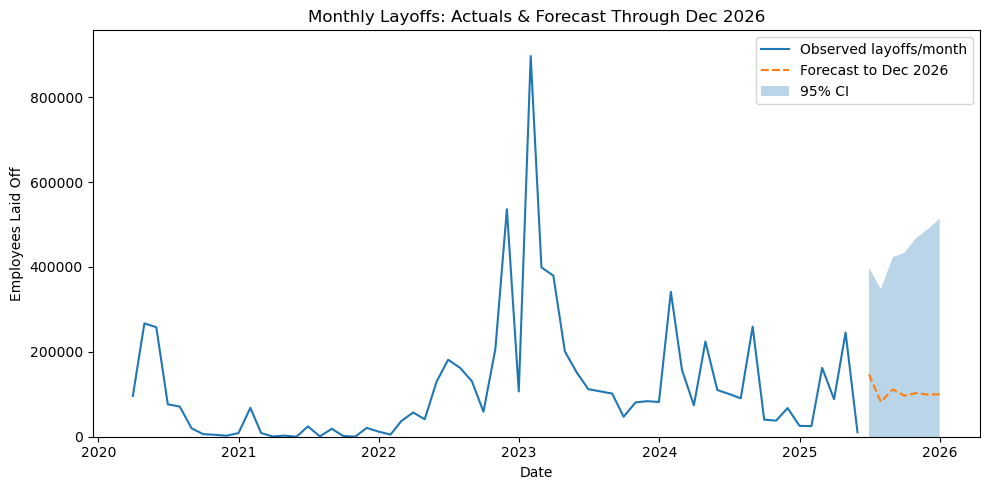

RF CV RMSE: [150194.91222633785, 233127.98789781544, 103963.35126927502]
RF next-month forecast: [164787.7]


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# 1. Load & clean
df = pd.read_csv('Layoffs.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['# Laid Off'] = (
    df['# Laid Off'].astype(str)
      .str.replace(r'[^\d]', '', regex=True)
      .replace('', '0')
      .astype(int)
)
df = df.dropna(subset=['Date', '# Laid Off'])

# 2. Build monthly series
ts = (
    df.set_index('Date')['# Laid Off']
      .resample('M').sum()
      .asfreq('M', fill_value=0)
      .rename('monthly_layoffs')
)

# 3. RF feature engineering
features = pd.DataFrame(ts)
features['lag_1']  = features['monthly_layoffs'].shift(1)
features['roll_3'] = features['monthly_layoffs'].rolling(3).mean().shift(1)
features = features.dropna()

# 4. SARIMAX with linear trend
model = SARIMAX(ts, order=(1,1,1), trend='t').fit(disp=False)

# forecast through Dec 2026
last = ts.index[-1]
months_to_2025 = (2025 - last.year)*12 + (12 - last.month)
fc = model.get_forecast(steps=months_to_2025)
fc_mean = fc.predicted_mean
fc_conf = fc.conf_int()

# 5. Plot with updated horizon
plt.figure(figsize=(10,5))
plt.plot(ts, label='Observed layoffs/month')
plt.plot(fc_mean, '--', label='Forecast to Dec 2026')
plt.fill_between(
    fc_conf.index,
    fc_conf.iloc[:,0],
    fc_conf.iloc[:,1],
    alpha=0.3,
    label='95% CI'
)
plt.title("Monthly Layoffs: Actuals & Forecast Through Dec 2026")
plt.xlabel("Date")
plt.ylabel("Employees Laid Off")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.show()

# 6. RF regression (unchanged)
X = features[['lag_1','roll_3']]
y = features['monthly_layoffs']
tscv = TimeSeriesSplit(n_splits=3)
rmse = []
for ti, vi in tscv.split(X):
    rf = RandomForestRegressor(100, random_state=42)
    rf.fit(X.iloc[ti], y.iloc[ti])
    rmse.append(np.sqrt(mean_squared_error(y.iloc[vi], rf.predict(X.iloc[vi]))))
print("RF CV RMSE:", rmse)

# 1-step RF forecast
last_row = features.iloc[-1][['lag_1','roll_3']].to_frame().T
print("RF next-month forecast:", rf.predict(last_row))

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/3050121111.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'Industry'])['# Laid Off']
/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/3050121111.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


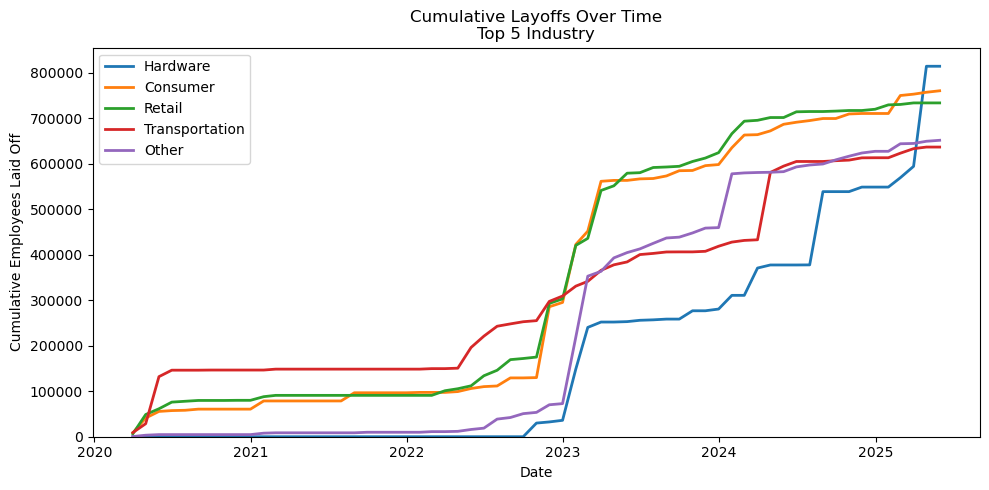

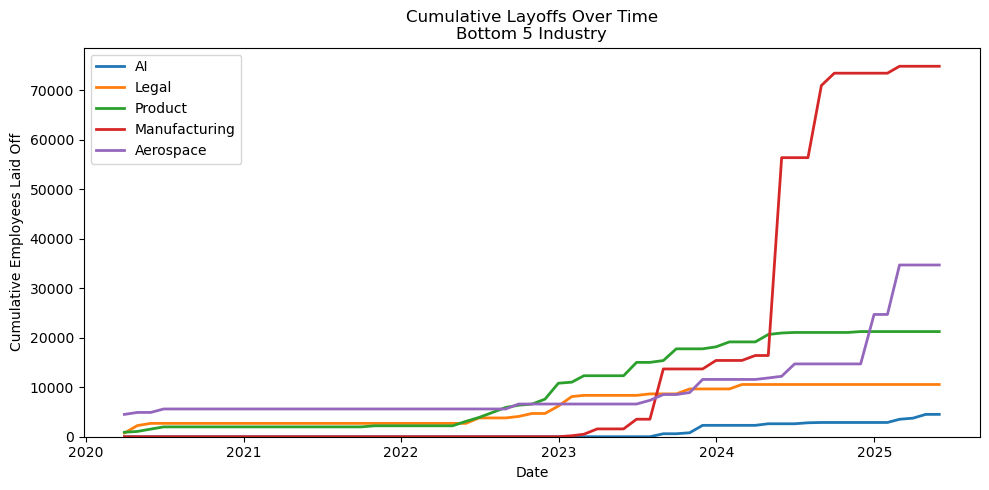

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/3050121111.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


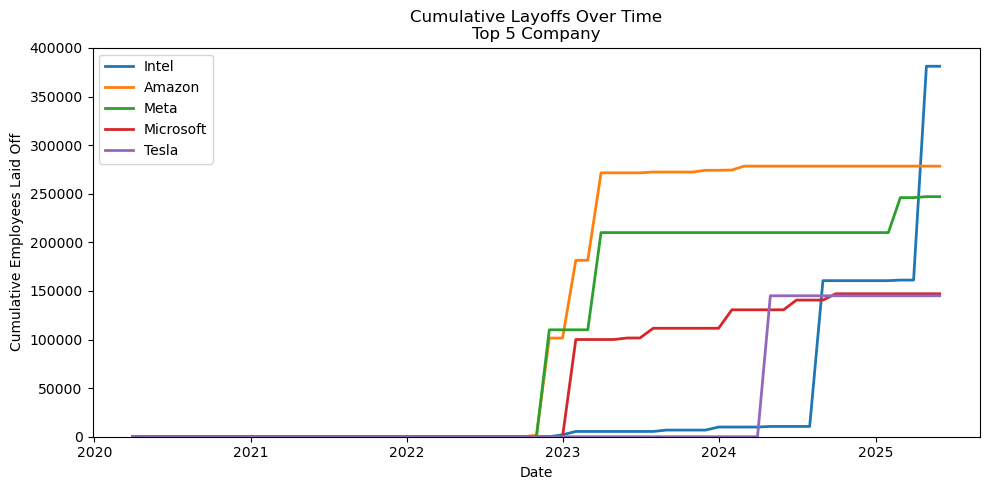

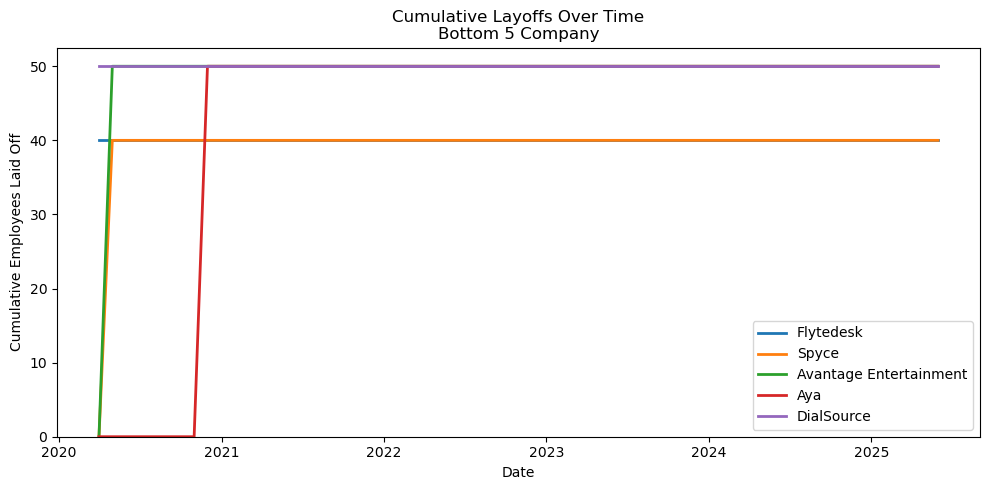

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/3050121111.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


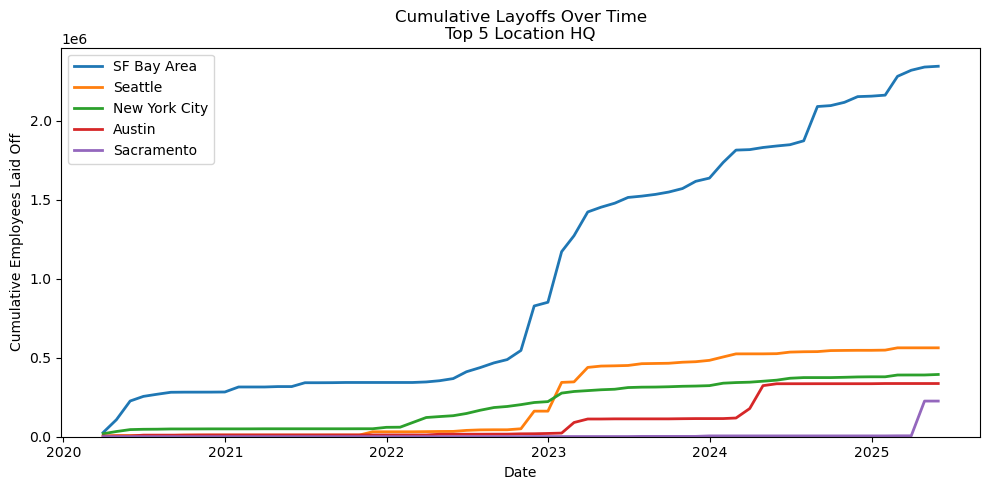

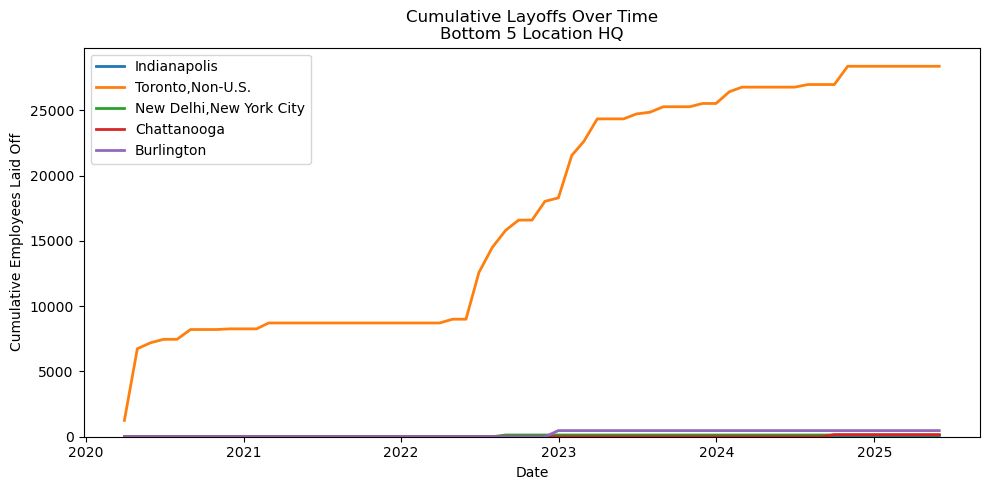

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/3050121111.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


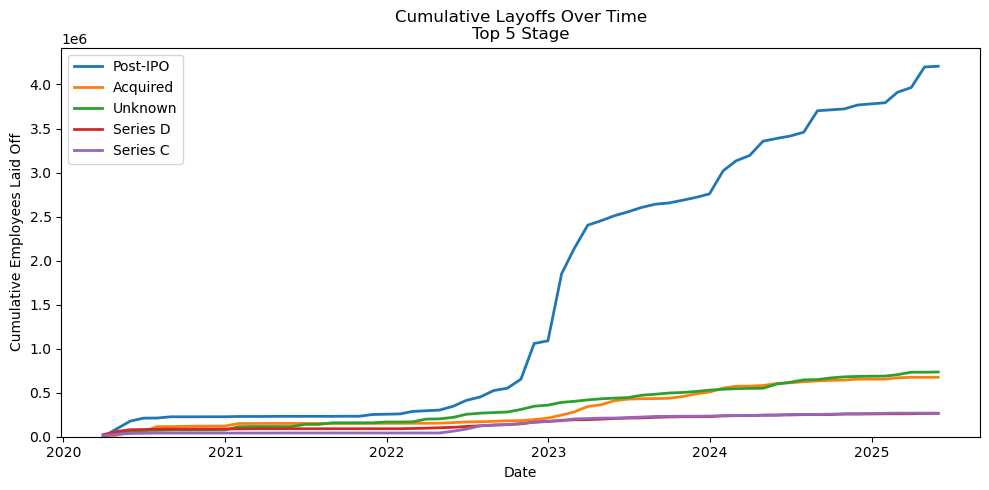

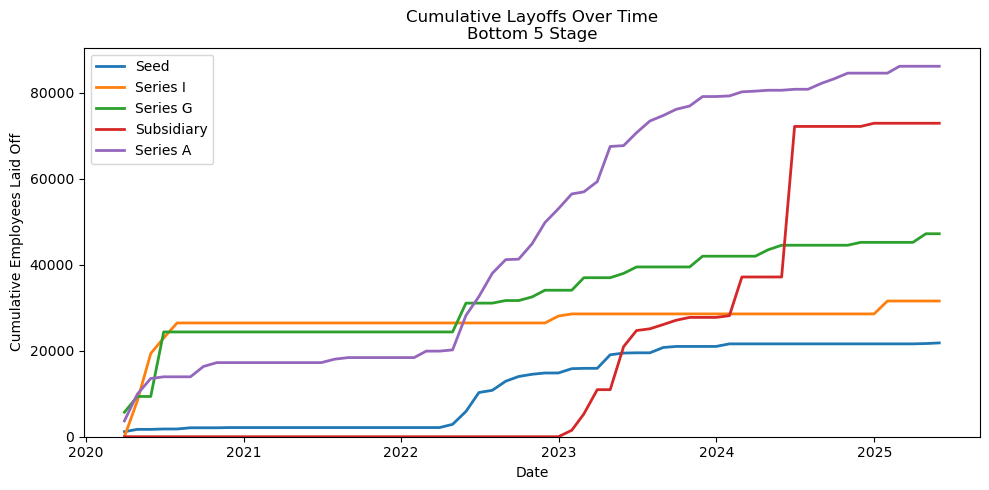

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare monthly cumulative series
monthly = (
    df.set_index('Date')
      .groupby([pd.Grouper(freq='M'), 'Industry'])['# Laid Off']
      .sum()
      .reset_index()
)

# Filter for U.S. data
df_us = df[df['Country'] == 'United States']

# Define categories
categories = ['Industry', 'Company', 'Location HQ', 'Stage']

for cat in categories:
    # Total layoffs per entity
    total = df_us.groupby(cat)['# Laid Off'].sum()
    total_pos = total[ total > 0 ]
    top5    = total_pos.nlargest(5).index
    bottom5 = total_pos.nsmallest(5).index

    # Pivot to time series
    monthly = (
        df.set_index('Date')
          .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']
          .sum()
          .reset_index()
    )
    pivot = monthly.pivot(index='Date', columns=cat, values='# Laid Off').fillna(0)
    cum = pivot.cumsum()

    # Plot Top 5
    plt.figure(figsize=(10, 5))
    for name in top5:
        plt.plot(cum.index, cum[name], label=name, lw=2)
    plt.title(f'Cumulative Layoffs Over Time\nTop 5 {cat}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Employees Laid Off')
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Bottom 5
    plt.figure(figsize=(10, 5))
    for name in bottom5:
        plt.plot(cum.index, cum[name], label=name, lw=2)
    plt.title(f'Cumulative Layoffs Over Time\nBottom 5 {cat}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Employees Laid Off')
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/133357164.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


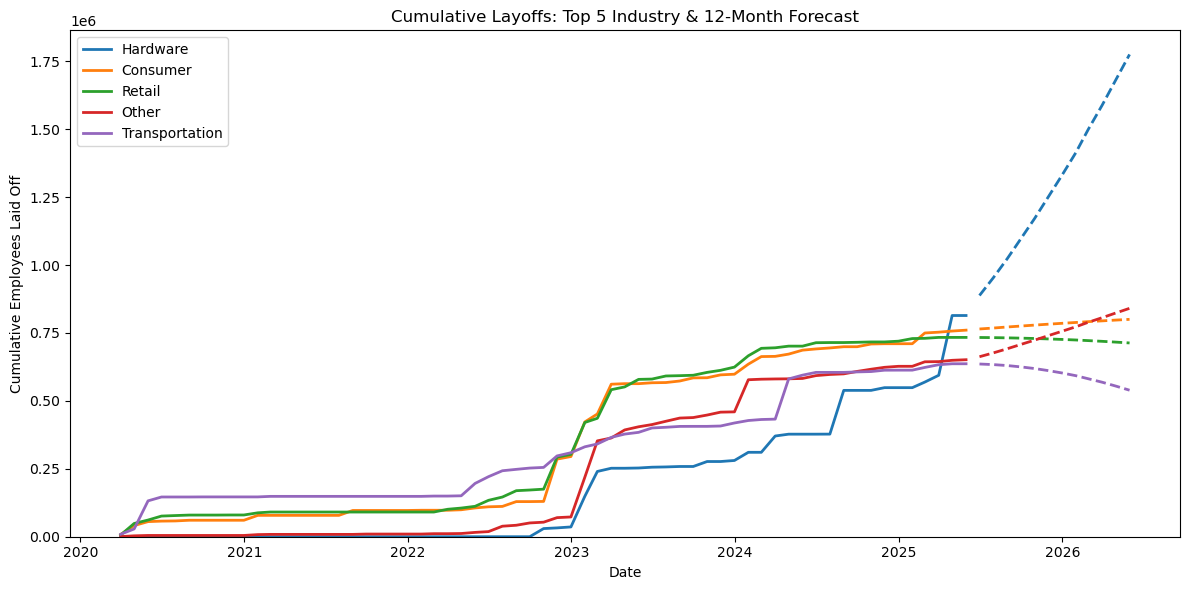

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/133357164.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


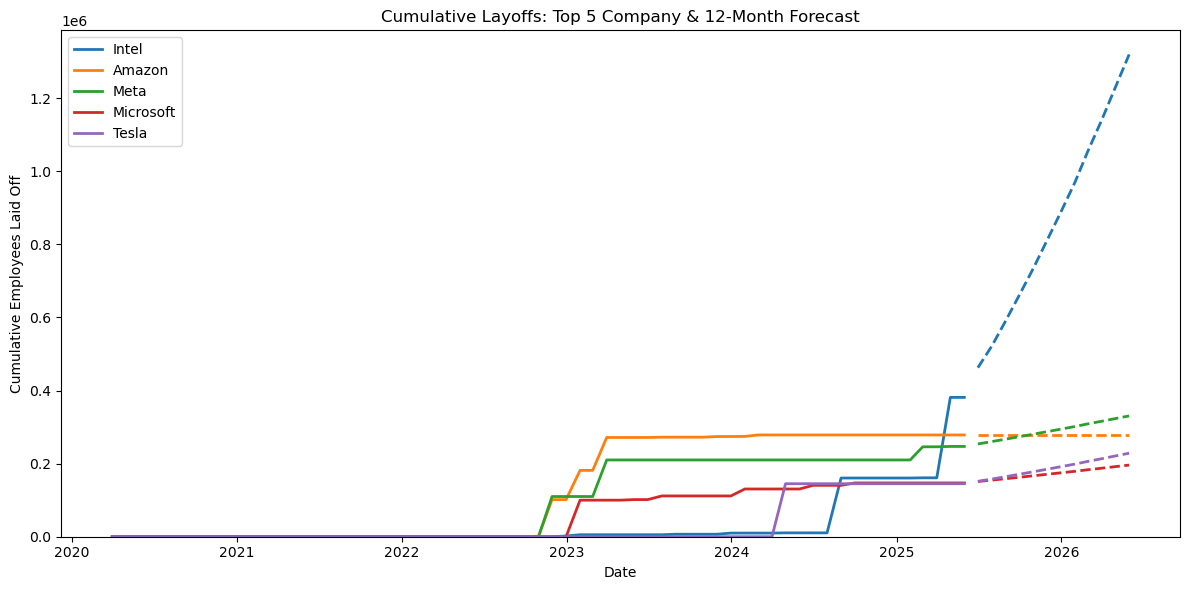

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/133357164.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


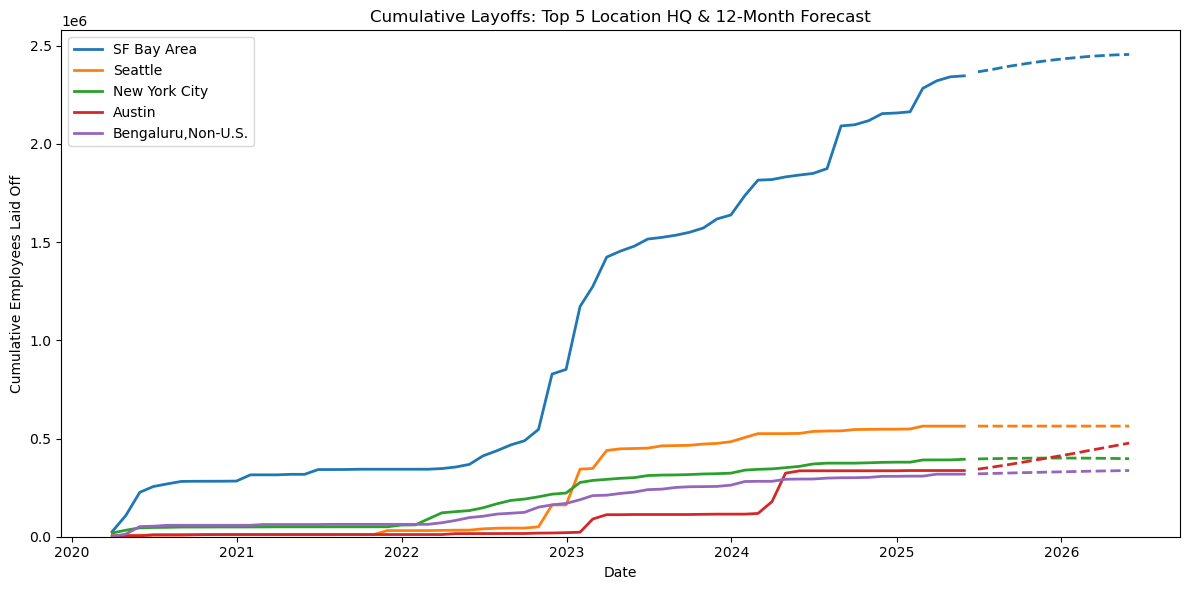

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/133357164.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


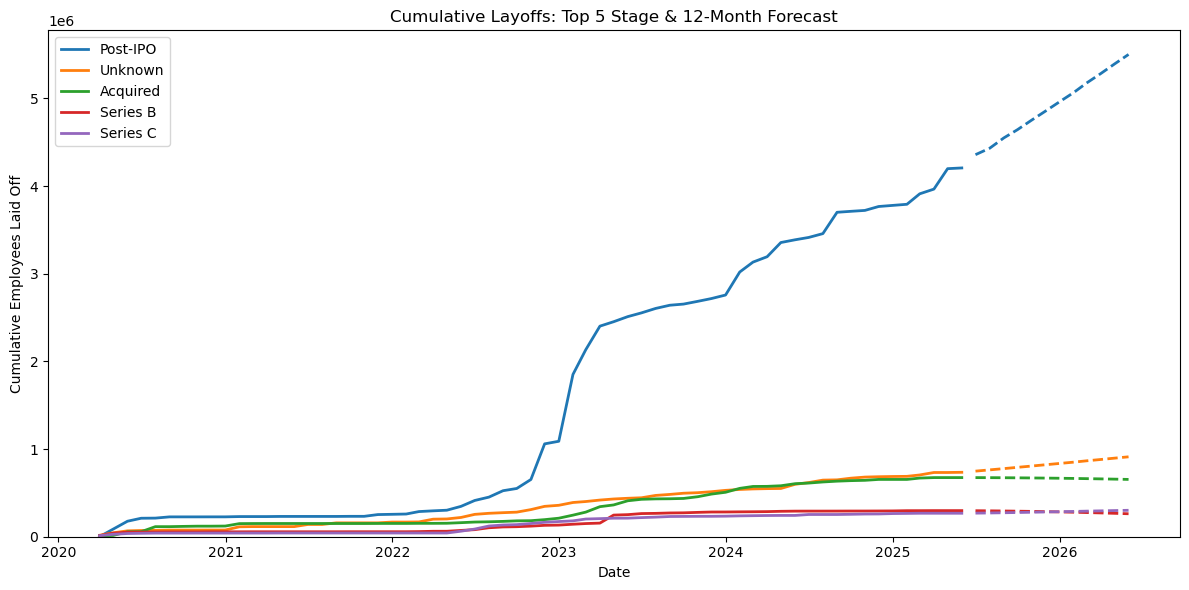

/var/folders/jf/kyt7scj10bj_lwv7fvj43r600000gn/T/ipykernel_11300/133357164.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']


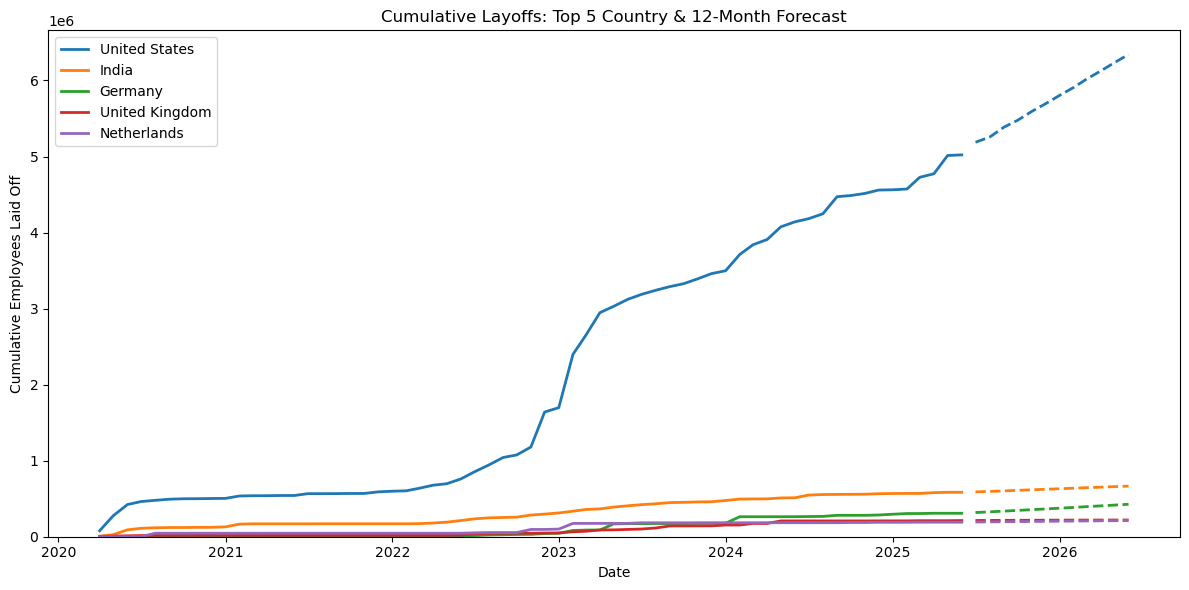

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Forecast horizon: next 12 months
forecast_steps = 12

categories = ['Industry', 'Company', 'Location HQ', 'Stage', 'Country']

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for cat in categories:
    # Filter and select top 5 by total layoffs
    total = df.groupby(cat)['# Laid Off'].sum()
    top5 = total.nlargest(5).index

    # Build monthly series for each top entity
    pivot = (
        df.set_index('Date')
          .groupby([pd.Grouper(freq='M'), cat])['# Laid Off']
          .sum()
          .unstack(cat)
          .fillna(0)
    )
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for idx, name in enumerate(top5):
        ts = pivot[name]
        model = SARIMAX(ts, order=(1,1,1), trend='c').fit(disp=False)
        fc = model.get_forecast(steps=forecast_steps)

        # Historical cumulative series
        hist_cum = ts.cumsum()
        color = colors[idx % len(colors)]
        ax.plot(hist_cum.index, hist_cum, label=name, color=color, linewidth=2)

        # Forecast cumulative, same color, no label
        forecast_cum = hist_cum.iloc[-1] + fc.predicted_mean.cumsum()
        ax.plot(forecast_cum.index, forecast_cum, linestyle='--', color=color, linewidth=2)

    ax.set_title(f'Cumulative Layoffs: Top 5 {cat} & {forecast_steps}-Month Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Employees Laid Off')
    ax.set_ylim(bottom=0)
    ax.legend()
    plt.tight_layout()
    plt.show()